In [1]:
from crp.attribution import CondAttribution
from zennit.attribution import Gradient
from zennit.canonizers import CompositeCanonizer
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.visualization import FeatureVisualization
from crp.image import plot_grid

from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
import zennit as zen
import torch.nn as nn
import torch
import zennit.torchvision as ztv
from crp.image import imgify


from relevance import plot_relevance
from model import get_vggs_and_path, get_resnets_and_path, get_remote_models_and_path, get_remote_models_and_path_mki67
from plot_and_print import plot_tile
from data_loader import TileLoader
import os
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from data_loader import get_data_loaders, get_dataset_for_plotting, STDataset

%matplotlib inline
import torchvision.transforms as T

<All keys matched successfully>
<All keys matched successfully>


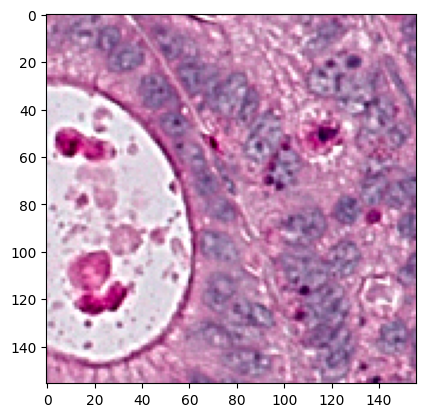

In [2]:

models_mki67 = get_remote_models_and_path_mki67()
img_paths = []
img_paths.append("../Test_Data/p026/tiles/p026_11_60.tiff")

loader = TileLoader()
for path in img_paths:
    data = loader.open(path).unsqueeze(0)
    data.requires_grad_(True)
    plot_tile(path)
    
cc = ChannelConcept()

data_dir = "../Training_Data/"
dataset = get_dataset_for_plotting(data_dir)

In [3]:
def plot_most_relevant_channels(data_path, model, model_path, sample_count = 5, figwidth = 15, fightheight = 15):
    
    position = model_path.find('/models/') + len('/models/')
    base_path = "../crp_out/" + model_path[position:-3]
    print("output path:", base_path)
    data = loader.open(data_path).unsqueeze(0)
    data.requires_grad_(True)
    #print(type(model.encoder))
    if type(model.encoder).__name__ == "VGG":
        composite = zen.composites.EpsilonPlusFlat(canonizers=[ztv.VGGCanonizer()])
    else:
        composite = zen.composites.EpsilonPlusFlat(canonizers=[ztv.ResNetCanonizer()])
        
    print("selected", type(composite.canonizers[0]).__name__, "for model", model_path)
    attribution = CondAttribution(model, no_param_grad=True)
    #print(model)
    if type(model.encoder).__name__ == "VGG":
        layer_type = model.encoder.classifier[-1].__class__
        print(model.encoder.classifier[-1])
        layer_name = get_layer_names(model, [nn.Linear])[-3]
    else:
        layer_type = model.encoder.layer1[0].__class__
        # select last bottleneck module
        layer_name = get_layer_names(model, [layer_type])[-1]
    conditions = [{'y': [0]}]
    print("layer_name for attribution:", layer_name)
    attr = attribution(data, conditions, composite, record_layer=[layer_name])
    cc = ChannelConcept()
    rel_c = cc.attribute(attr.relevances[layer_name], abs_norm=True)
    rel_values, concept_ids = torch.topk(rel_c[0], sample_count)
    print(concept_ids, rel_values*100)
    layer_names = get_layer_names(model, [layer_type])
    layer_map = {layer : cc for layer in layer_names}
    
    preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #if the file exists then just plot
    if os.path.exists(base_path):
        fv = FeatureVisualization(attribution, dataset, layer_map, preprocess_fn=preprocessing, path=base_path)
    else:
        fv = FeatureVisualization(attribution, dataset, layer_map, preprocess_fn=preprocessing, path=base_path)
        saved_files = fv.run(composite, 0, len(dataset), 128, 100)
    ref_c = fv.get_max_reference(concept_ids, "encoder.layer4.1", "relevance", (0, 8), composite=composite, plot_fn=None)
    plot_grid(ref_c, figsize=(figwidth, fightheight))

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
../remote_models/new/models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt
output path: ../crp_out/res18/RUBCNL_Res18/Res18_1000_ep_29
selected ResNetCanonizer for model ../remote_models/new/models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt
layer_name for attribution: pretrained.layer4.1
tensor([180, 422, 476, 446,  77]) tensor([2.1730, 1.5149, 1.2771, 1.0671, 1.0163])


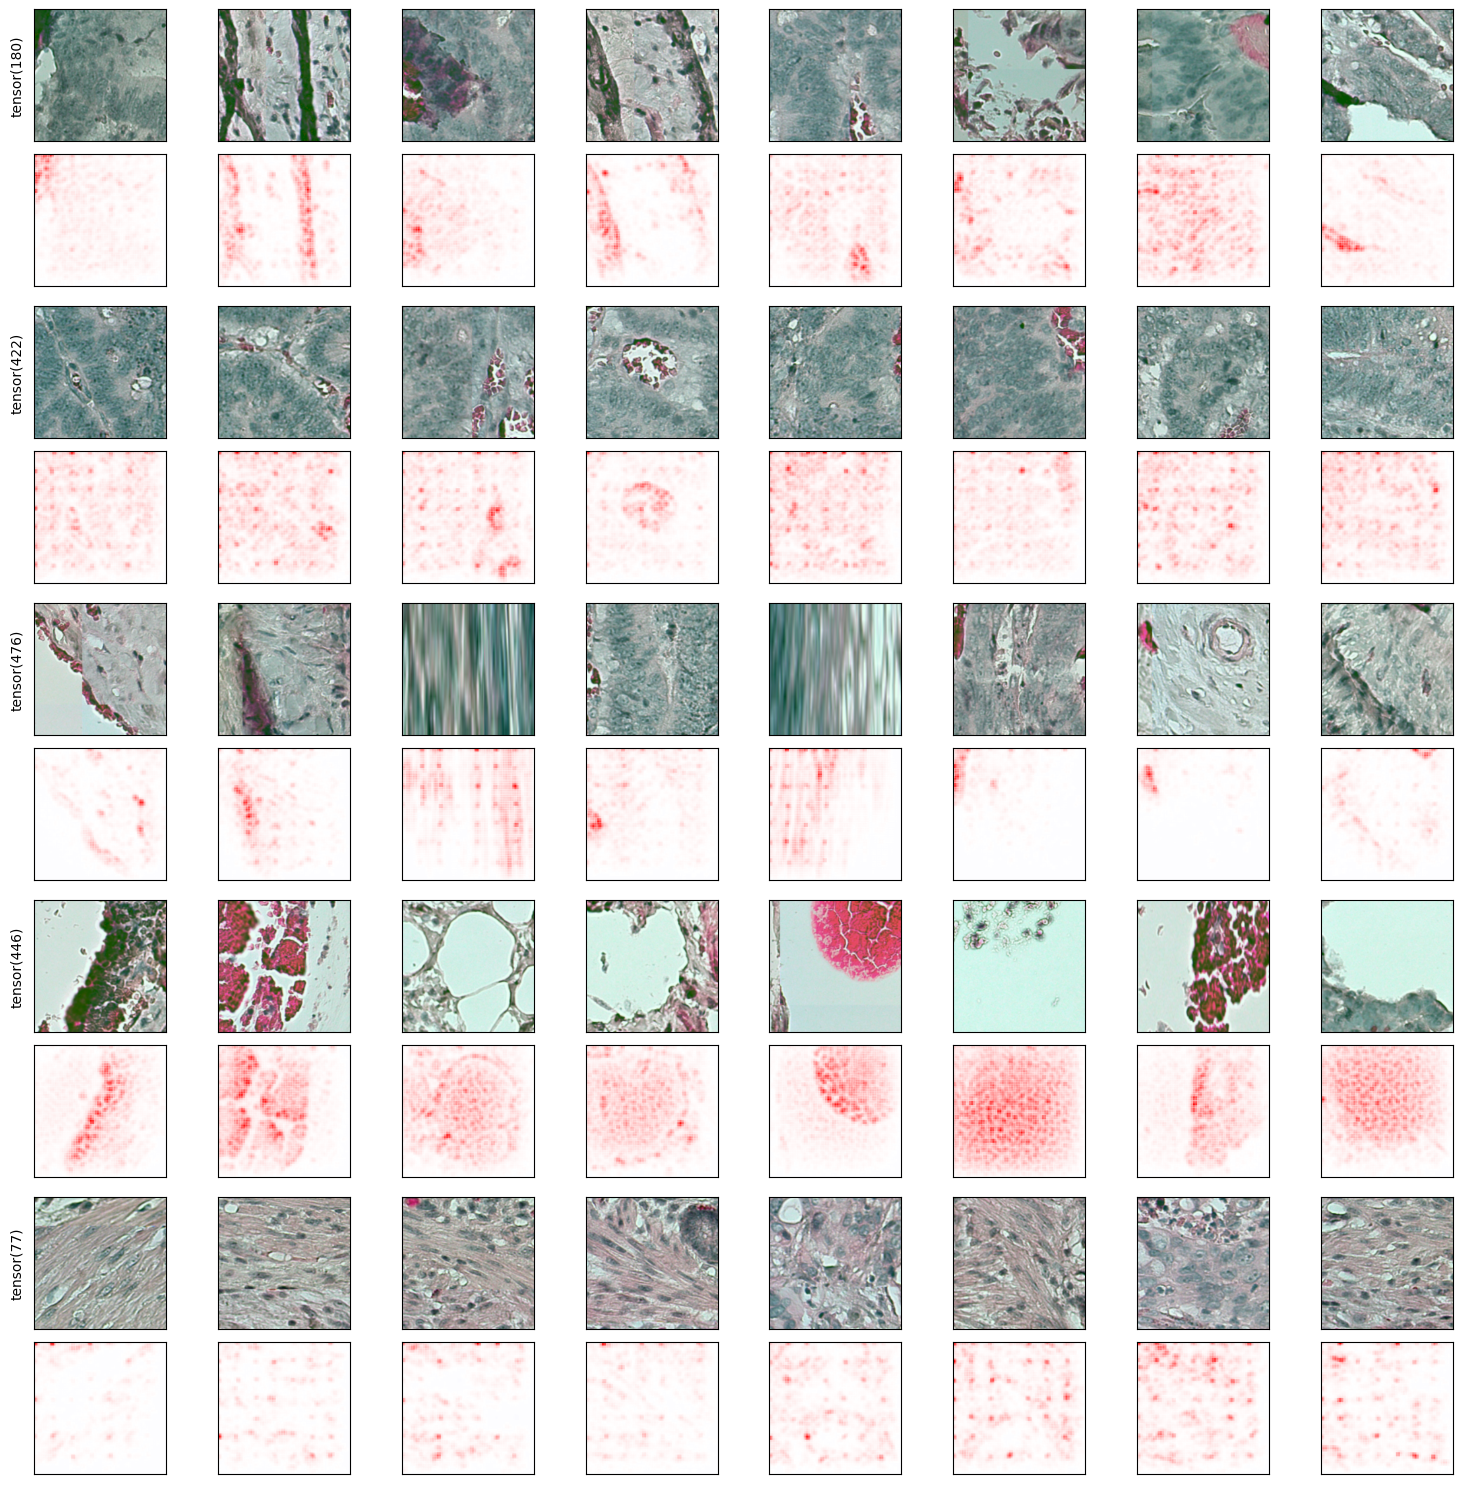

In [5]:
skips = 0

models = get_remote_models_and_path()
for model, model_path in models:
    print(model_path)
    if skips > 0:
        skips -= 1
        continue
    
    plot_most_relevant_channels(img_paths[0], model, model_path)
    break

In [24]:
#print("model_numbers range from 0 to", len(models)-1)
# select a model
model_number = 8
model, model_path = models[model_number]
for path in img_paths:
    plot_most_relevant_channels(path, model, model_path)

In [15]:
for model, model_path in models_mki67:
    for path in img_paths:
        plot_most_relevant_channels(path, model, model_path)
    break
    